Jako malí jsme hrávali hru na hledání pokladu. Jeden v pokoji schoval nějaký poklad, a ostatním jej pak hledali s nápovědou: "samá voda, samá voda, přihořívá, hoří!".
Vzpomněl jsem si na to, když jsem si četl zadání úkolu [Shadows of the Knight - Episode 2](https://www.codingame.com/training/expert/shadows-of-the-knight-episode-2) na CodingGame.

Po prvním přečtení zadání jsem si dost naivně říkal, tak v čem je problém? Napovídají, že je dobré použít binární hledání a dělení intervalu. To vše umím, tak rovnou na to.

Nakonec to zase tak jednoduché nebylo.

Tak o co vlastně šlo?

# Zadání úkolu
Dostanu zadané dvourozměrné pole o velikosti WIDTH x HEIGHT políček. Na jednom políčku je umístěna bomba, kterou mám najít. 

Hra začíná tak, že se objevím na nějakém místě v tomto poli. Mohu skočit na libovolné políčko v tomto dvourozměrném poli. Po každém skoku dostanu informaci, jestli jsem blíže, dále nebo stejně daleko od bomby. Vzdálenost se v tomto případě počítá jako _Euklejdovská vzdálenost_ ve dvourozměrném prostoru.

Úkolem je co nejmenším počtem skoků najít políčko s bombou.


# Základní úvahy o řešení
Jak už sami autoři hry naznačovali, je dobré použít binární hledání.
Obvykle se tento postup prezentuje na jednoduchém setříděném poli. V tomto případě jsem ve dvou dimenzích, ale mělo by to jít použít stejně. 

Nejdříve budu hledat v jednom rozměru, např. v jednom řádku. Až najdu tu správnou pozici v řádku, budu hledat ve sloupci.

Postup hledání v jednom rozměru je takový, že se snažím každým skokem rozdělit celý interval na dvě poloviny. Na polovinu, která je blíže bombě, no a na tu druhou, která je dále od bomby. V dalším kroku pak opět dělím ten interval blíže bomby. A to vše tak dlouho, dokud se mně interval nesmrskne na jedno políčko.

## Dělení intervalu skokem
Musel jsem si to namalovat, abych viděl, jak je třeba skákat, abych rozpůlil interval.

Jsou tam totiž dvě možné situace:

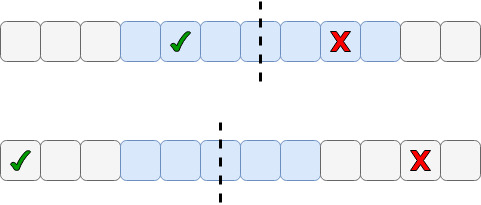

Ta zelená fajfka představuje moji aktuální pozici. Červený křížek pak pozici, kam bych měl skočit, abych rozdělil interval na dvě poloviny.

V prvém případě aktuálně stojím uvnitř intervalu, který chci rozdělit. Cílová pozice je tedy opět uvnitř intervalu symetricky vůči středu. 

Ve druhém případě aktuálně stojím vně intervalu. Pak má cílová pozice musí být opět vně intervalu symetricky vůči jeho středu.

A to je asi ta nejzásadnější úvaha. Následuje již pouze programátorská dřina.

# Příprava testovacího prostředí

Nejdříve nějaké knihovny a základní inicializace:

In [1]:
import random
import math

Připravím si testovací třídu, jejimž úkolem bude poskytovat informaci o mé poloze vůči bombě:

In [2]:
class TestSuite2D:

    def __init__(self, width, height, target=None):
        self.target = (random.randrange(width), random.randrange(height)) if target is None else target
        self.last = None

    def evaluate(self, value):
        if self.last is not None:
            if value == self.target:
                result = "FOUND"
            else:
                def euclidean_distance(a, b):
                    return ((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) ** 0.5

                distance_last = euclidean_distance(self.target, self.last)
                distance_value = euclidean_distance(self.target, value)
                if distance_value > distance_last:
                    result = 'COLDER'
                elif distance_value < distance_last:
                    result = 'WARMER'
                else:
                    result = 'SAME'
        else:
            result = 'UNKNOWN'
        self.last = value
        return result

    def validate(self, value):
        return self.target == value

    def __str__(self):
        return f"TestSuite2D[target={self.target}, last={self.last}]"

Při inicializaci zadávám rozměry pole a pozici bomby. Pokud pozici bomby nezadám, pak se umístí náhodně.

Z instance této třídy budu volat metodu __evaluate__ se zadanou aktuální mojí pozicí. 

Očekávám některou z těchto odpovědí:
* WARMER  - jsem blíže bombě
* COLDER  - jsem dále bombě
* SAME    - jsem ve stejné vzdálenosti od bomby
* FOUND   - našel jsem ji
* UNKNOWN - při prvním dotazu, protože neexistuje moje předchozí pozice


# Hledání v jednom řádku

Nejdříve jsem si vytvořil funkci pro hledání v jednom řádku. 
Pro testování budu používat testovací třídu pro 2D, takže bych si měl ověřit i závislost na Euklejdovské vzdálenosti.

## Funkce pro hledání v jednom rozměru

In [3]:
def binary_search_1d(width, x0, f):

    lower_x, upper_x, prev_x, x = 0, width - 1, x0, x0

    def next_index(low, high, max_x, curr):
        i = high + low - curr
        if i == curr:
            i = i - 1 if curr > 0 else i + 1
        return max(0, min(max_x, i))

    while True:

        check_distance = f((x, 0))

        if check_distance == 'WARMER':
            if x < prev_x and lower_x < upper_x:
                upper_x = prev_x - math.ceil((abs(x - prev_x) + 1) / 2)
            elif x > prev_x and lower_x < upper_x:
                lower_x = prev_x + math.ceil((abs(x - prev_x) + 1) / 2)

        elif check_distance == 'COLDER':
            if x < prev_x and lower_x < upper_x:
                lower_x = x + math.ceil((abs(x - prev_x) + 1) / 2)
            elif x > prev_x and lower_x < upper_x:
                upper_x = x - math.ceil((abs(x - prev_x) + 1) / 2)

        elif check_distance == 'SAME':
            return (x + prev_x) // 2

        elif check_distance == 'UNKNOWN':
            pass

        elif check_distance == 'FOUND':
            return x

        else:
            raise ValueError

        prev_x, x = x, next_index(lower_x, upper_x, width - 1, x) if lower_x < upper_x else lower_x

    return x


# Ověření, že funguje správně

Udělal jsem si několik testovacích běhů přes rozměr pole 1, lichý a sudý. V každém rozměru pak udělám všechny kombinace pro možnou pozici bomby a startovací pozici.
Tím bych měl ověřit, že mně algoritmus funguje ve všech situacích:

In [4]:
HEIGHT, j = 9, 5
for WIDTH in (1, 10, 11):
    for i in range(WIDTH):
        for x in range(WIDTH):
            suite = TestSuite2D(WIDTH, HEIGHT, (i, j))
            res = binary_search_1d(WIDTH, x, lambda x: suite.evaluate(x))
            if not suite.validate((res, j)):
                print("FAILED")
print("FINISHED")

FINISHED


# Hledání ve dvouorozměrném poli

Tady se tedy již dostávám ke konečnému řešení.

Hledám nejdříve v řádku, a pak ve sloupci:

In [5]:
def binary_search_2d_next(width, height, point, f):

    lower_x, upper_x, prev_x, x = 0, width - 1, point[0], point[0]
    lower_y, upper_y, prev_y, y = 0, height - 1, point[1], point[1]

    def next_index(low, high, max_i, curr):
        i = high + low - curr
        if i == curr:
            i = i - 1 if curr > 0 else i + 1
        elif i > max_i:
            i = high
        elif i < 0:
            i = low
        return i

    while True:

        check_distance = f((x, y))

        if check_distance == 'WARMER':
            if x < prev_x and lower_x < upper_x:
                upper_x = prev_x - math.ceil((abs(x - prev_x) + 1) / 2)
            elif x > prev_x and lower_x < upper_x:
                lower_x = prev_x + math.ceil((abs(x - prev_x) + 1) / 2)
            elif y < prev_y and lower_y < upper_y:
                upper_y = prev_y - math.ceil((abs(y - prev_y) + int(x == prev_x)) / 2)
            elif y > prev_y and lower_y < upper_y:
                lower_y = prev_y + math.ceil((abs(y - prev_y) + int(x == prev_x)) / 2)

        elif check_distance == 'COLDER':
            if x < prev_x and lower_x < upper_x:
                lower_x = x + math.ceil((abs(x - prev_x) + 1) / 2)
            elif x > prev_x and lower_x < upper_x:
                upper_x = x - math.ceil((abs(x - prev_x) + 1) / 2)
            elif y < prev_y and lower_y < upper_y:
                lower_y = y + math.ceil((abs(y - prev_y) + int(x == prev_x)) / 2)
            elif y > prev_y and lower_y < upper_y:
                upper_y = y - math.ceil((abs(y - prev_y) + int(x == prev_x)) / 2)

        elif check_distance == 'SAME':
            if x != prev_x and lower_x < upper_x:
                lower_x, upper_x = (x + prev_x) // 2, (x + prev_x) // 2
            if y != prev_y and lower_y < upper_y and x == prev_x:
                lower_y, upper_y = (y + prev_y) // 2, (y + prev_y) // 2

        elif check_distance == 'UNKNOWN':
            pass

        elif check_distance == 'FOUND':
            break

        else:
            raise ValueError

        prev_x, x = x, next_index(lower_x, upper_x, width - 1, x) if lower_x < upper_x else lower_x

        if prev_x == x or (lower_x == upper_x and abs(prev_x - x) <= 1):
            prev_y, y = y, next_index(lower_y, upper_y, height - 1, y) if lower_y < upper_y else lower_y

    return x, y

## Ověření, že to funguje

Budu opět ověřovat pro rozměry 1, sudý a lichý. V tomto případě se to bude týkat jak šířky pole, tak jeho délky.

Opět udělám testy, kdy ověřím všechny možné pozice bomby a startovací pozice:

In [6]:
for WIDTH in (1, 10, 11):
    for HEIGHT in (1, 10, 11):
        for i in range(WIDTH):
            for j in range(HEIGHT):
                for x in range(WIDTH):
                    for y in range(HEIGHT):
                        suite = TestSuite2D(WIDTH, HEIGHT, (i, j))
                        res = binary_search_2d_next(WIDTH, HEIGHT, (x, y), lambda x: suite.evaluate(x))
                        if not suite.validate(res):
                            print("FAILED")

print("FINISHED")

FINISHED
